In [1]:
# lib
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import time

import lightgbm as lgbm

from fastprogress import master_bar, progress_bar
from glob import glob
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score


def seed_everything(seed=7777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #tf.random.set_seed(seed)
    np.random.seed(seed)


SEED = 7777
seed_everything(SEED)
pd.set_option('display.max_columns', 200)

In [2]:
data_path = '../input/jane-street-market-prediction/'

In [3]:
def save_pickle(dic, save_path):
    with open(save_path, 'wb') as f:
    # with gzip.open(save_path, 'wb') as f:
        pickle.dump(dic, f)

def load_pickle(load_path):
    with open(load_path, 'rb') as f:
    # with gzip.open(load_path, 'rb') as f:
        dic = pickle.load(f)
    return dic


def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 7777


# data

In [4]:
# load
train_df = dt.fread(data_path + 'train.csv').to_pandas()
train_df = train_df.query('date > 85').reset_index(drop=True)

# fill na
train_df_median = train_df.median().to_frame().T
#train_df_median.to_csv('train_df_median.csv', index=False)
#train_df_median = pd.read_csv('train_df_median.csv')
train_df.fillna(train_df_median, inplace=True)

# drop weight == 0
train_df = train_df[train_df['weight'] != 0].reset_index(drop=True)

In [5]:
# add feature
train_df['feature_41_42_43'] = (train_df.feature_41 + 
                                train_df.feature_42 +
                                train_df.feature_43)
esp = 1e-8
train_df['feature_1_2'] = ((train_df.feature_1 + esp) /
                           (train_df.feature_2 + esp))

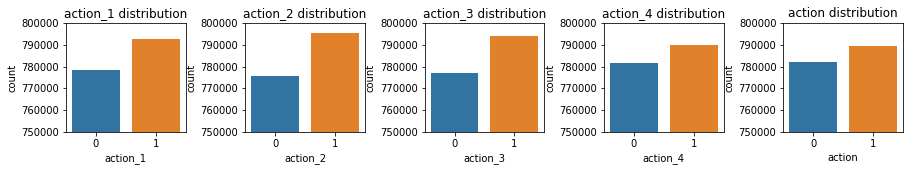

In [6]:
# feature name
features = [c for c in train_df.columns if "feature" in c]
#feature_names = train_df.columns[train_df.columns.str.contains('feature')].to_list()
features.remove('feature_0')


# create action
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']
action_cols = []

for resp in resp_cols:
    action = resp.replace('resp', 'action')
    action_cols.append(action)
    train_df[action] = (train_df[resp] * train_df['weight'] > 0).astype(int)
    
plt.figure(figsize=(15, 2))
for i, action in enumerate(action_cols, 1):
    plt.subplot(1, 5, i)
    plt.ylim(7.5e5, 8.0e5)
    sns.countplot(train_df[action])
    
    plt.title(f'{action} distribution')
    plt.subplots_adjust(wspace=0.5)
plt.show()

In [7]:
x_data = train_df[features].values
y_data = train_df[action_cols].values
groups = train_df['date'].values

# PurgedGroupTimeSeriesSplit

In [10]:
# PurgedGroupTimeSeriesSplit
# https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose
        
    def __len__(self): 
        return self.n_splits

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [11]:
# plot_cv_indices
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [12]:
cv = PurgedGroupTimeSeriesSplit(
    #max_train_group_size=200,
    group_gap=20,
)

144426 237204
372534 263792
621401 270184
889748 282063
1175505 312613


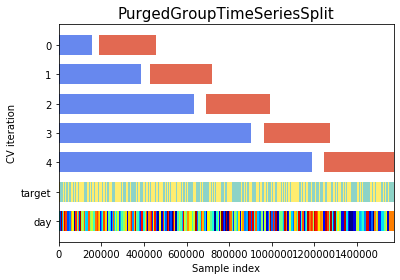

In [9]:
# plot cv
for i, (trn_idx, val_idx) in enumerate(cv.split(x_data, y_data, groups=groups)):
    print(len(trn_idx), len(val_idx))
    
fig, ax = plt.subplots()
plot_cv_indices(cv, x_data, y_data[:, 4], groups, ax, 5, lw=20);

# train cls

In [15]:
params = {
    "num_leaves": 300,
    "max_bin": 450,
    "feature_fraction": 0.52,
    "bagging_fraction": 0.52,
    "objective": "binary",
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "metric": "auc"
}

# multi folds
models = {}
mb = master_bar(cv.split(x_data,  y_data, groups=groups), total=5)
for fold, (trn_idx, val_idx) in enumerate(mb):
    logger.info(f'fold {fold}:')
    # multi labels
    fold_models = []
    pb = progress_bar(range(y_data.shape[1]), parent=mb)
    for i in pb:
        x_train = x_data[trn_idx]
        y_train = y_data[trn_idx, i]
        x_val = x_data[val_idx]
        y_val = y_data[val_idx, i]

        # lgbm dataset
        train_data = lgbm.Dataset(x_train, y_train)
        val_data = lgbm.Dataset(x_val, y_val, reference=train_data)
        
        # train
        clf = lgbm.train(params,
                         train_data,
                         valid_sets=[train_data, val_data],
                         num_boost_round=1000,
                         early_stopping_rounds=50,
                         verbose_eval=50)
        # record
        logger.info(f'model {i}: ')
        trn_preds = (clf.predict(x_train)>0.5).astype(int)
        val_preds = (clf.predict(x_val)>0.5).astype(int)
        logger.info(f'train acc: {accuracy_score(y_train, trn_preds): .4f}\t'  
                    f'val acc: {accuracy_score(y_val, val_preds): .4f}')
        logger.info(f'train auc: {roc_auc_score(y_train, trn_preds): .4f}\t'  
                    f'val auc: {roc_auc_score(y_val, val_preds): .4f}')        
        
        fold_models.append(clf)
    models[fold] = fold_models

fold 0:


[LightGBM] [Info] Number of positive: 72207, number of negative: 72219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499958 -> initscore=-0.000166
[LightGBM] [Info] Start training from score -0.000166
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.813644	valid_1's auc: 0.562514
[100]	training's auc: 0.896133	valid_1's auc: 0.561638


model 0: 


Early stopping, best iteration is:
[59]	training's auc: 0.831822	valid_1's auc: 0.562979


train acc:  0.7516	val acc:  0.5429
train auc:  0.7516	val auc:  0.5433


[LightGBM] [Info] Number of positive: 73124, number of negative: 71302
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506308 -> initscore=0.025232
[LightGBM] [Info] Start training from score 0.025232
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.827606	valid_1's auc: 0.549584


model 1: 


Early stopping, best iteration is:
[44]	training's auc: 0.815053	valid_1's auc: 0.550196


train acc:  0.7358	val acc:  0.5340
train auc:  0.7356	val auc:  0.5338


[LightGBM] [Info] Number of positive: 74168, number of negative: 70258
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513536 -> initscore=0.054159
[LightGBM] [Info] Start training from score 0.054159
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.867878	valid_1's auc: 0.514641


model 2: 


Early stopping, best iteration is:
[22]	training's auc: 0.789864	valid_1's auc: 0.51661


train acc:  0.6942	val acc:  0.5117
train auc:  0.6893	val auc:  0.5093


[LightGBM] [Info] Number of positive: 73936, number of negative: 70490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511930 -> initscore=0.047729
[LightGBM] [Info] Start training from score 0.047729
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.894566	valid_1's auc: 0.51774


model 3: 


Early stopping, best iteration is:
[31]	training's auc: 0.848716	valid_1's auc: 0.519314


train acc:  0.7411	val acc:  0.5138
train auc:  0.7374	val auc:  0.5128


[LightGBM] [Info] Number of positive: 73586, number of negative: 70840
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509507 -> initscore=0.038031
[LightGBM] [Info] Start training from score 0.038031
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.879502	valid_1's auc: 0.519674


model 4: 


Early stopping, best iteration is:
[13]	training's auc: 0.774931	valid_1's auc: 0.520388


train acc:  0.6759	val acc:  0.5152
train auc:  0.6720	val auc:  0.5127
fold 1:


[LightGBM] [Info] Number of positive: 187459, number of negative: 185075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503200 -> initscore=0.012799
[LightGBM] [Info] Start training from score 0.012799
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.700744	valid_1's auc: 0.570007
[100]	training's auc: 0.763376	valid_1's auc: 0.570163


model 0: 


Early stopping, best iteration is:
[62]	training's auc: 0.717719	valid_1's auc: 0.570805


train acc:  0.6562	val acc:  0.5481
train auc:  0.6562	val auc:  0.5482


[LightGBM] [Info] Number of positive: 189131, number of negative: 183403
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507688 -> initscore=0.030754
[LightGBM] [Info] Start training from score 0.030754
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.708864	valid_1's auc: 0.556144
[100]	training's auc: 0.776558	valid_1's auc: 0.556416


model 1: 


Early stopping, best iteration is:
[71]	training's auc: 0.740606	valid_1's auc: 0.556596


train acc:  0.6712	val acc:  0.5384
train auc:  0.6707	val auc:  0.5382


[LightGBM] [Info] Number of positive: 189751, number of negative: 182783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509352 -> initscore=0.037413
[LightGBM] [Info] Start training from score 0.037413
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.746915	valid_1's auc: 0.528167
[100]	training's auc: 0.813438	valid_1's auc: 0.529697
[150]	training's auc: 0.861454	valid_1's auc: 0.529052
Early stopping, best iteration is:
[108]	training's auc: 0.821813	valid_1's auc: 0.529784


model 2: 
train acc:  0.7316	val acc:  0.5200
train auc:  0.7300	val auc:  0.5188


[LightGBM] [Info] Number of positive: 188811, number of negative: 183723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506829 -> initscore=0.027317
[LightGBM] [Info] Start training from score 0.027317
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.771535	valid_1's auc: 0.521507


model 3: 


Early stopping, best iteration is:
[48]	training's auc: 0.768756	valid_1's auc: 0.521878


train acc:  0.6828	val acc:  0.5144
train auc:  0.6811	val auc:  0.5129


[LightGBM] [Info] Number of positive: 189046, number of negative: 183488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507460 -> initscore=0.029841
[LightGBM] [Info] Start training from score 0.029841
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.762295	valid_1's auc: 0.524487


model 4: 


Early stopping, best iteration is:
[48]	training's auc: 0.758352	valid_1's auc: 0.524941


train acc:  0.6765	val acc:  0.5169
train auc:  0.6748	val auc:  0.5158
fold 2:


[LightGBM] [Info] Number of positive: 312366, number of negative: 309035
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502680 -> initscore=0.010721
[LightGBM] [Info] Start training from score 0.010721
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.659266	valid_1's auc: 0.573436
[100]	training's auc: 0.705531	valid_1's auc: 0.575184
[150]	training's auc: 0.741306	valid_1's auc: 0.574747
Early stopping, best iteration is:
[106]	training's auc: 0.709822	valid_1's auc: 0.57525


model 0: 
train acc:  0.6495	val acc:  0.5509
train auc:  0.6495	val auc:  0.5509


[LightGBM] [Info] Number of positive: 314683, number of negative: 306718
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.312218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506409 -> initscore=0.025637
[LightGBM] [Info] Start training from score 0.025637
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.660087	valid_1's auc: 0.558329
[100]	training's auc: 0.713145	valid_1's auc: 0.558958


model 1: 


Early stopping, best iteration is:
[86]	training's auc: 0.700115	valid_1's auc: 0.559437


train acc:  0.6403	val acc:  0.5410
train auc:  0.6400	val auc:  0.5407


[LightGBM] [Info] Number of positive: 315362, number of negative: 306039
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507502 -> initscore=0.030009
[LightGBM] [Info] Start training from score 0.030009
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.695223	valid_1's auc: 0.534903
[100]	training's auc: 0.750293	valid_1's auc: 0.534462


model 2: 


Early stopping, best iteration is:
[62]	training's auc: 0.710143	valid_1's auc: 0.535773


train acc:  0.6428	val acc:  0.5248
train auc:  0.6415	val auc:  0.5238


[LightGBM] [Info] Number of positive: 314457, number of negative: 306944
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506045 -> initscore=0.024182
[LightGBM] [Info] Start training from score 0.024182
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.71997	valid_1's auc: 0.518042
[100]	training's auc: 0.78019	valid_1's auc: 0.518338
[150]	training's auc: 0.826809	valid_1's auc: 0.517252


model 3: 


Early stopping, best iteration is:
[104]	training's auc: 0.784639	valid_1's auc: 0.518727


train acc:  0.6957	val acc:  0.5142
train auc:  0.6947	val auc:  0.5135


[LightGBM] [Info] Number of positive: 314675, number of negative: 306726
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506396 -> initscore=0.025586
[LightGBM] [Info] Start training from score 0.025586
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.702955	valid_1's auc: 0.524286
[100]	training's auc: 0.769234	valid_1's auc: 0.524171


model 4: 


Early stopping, best iteration is:
[53]	training's auc: 0.70933	valid_1's auc: 0.524854


train acc:  0.6399	val acc:  0.5177
train auc:  0.6388	val auc:  0.5170
fold 3:


[LightGBM] [Info] Number of positive: 447869, number of negative: 441879
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.397720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503366 -> initscore=0.013465
[LightGBM] [Info] Start training from score 0.013465
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.637407	valid_1's auc: 0.574239
[100]	training's auc: 0.675399	valid_1's auc: 0.575827
[150]	training's auc: 0.704139	valid_1's auc: 0.576015
[200]	training's auc: 0.731157	valid_1's auc: 0.576246


model 0: 


Early stopping, best iteration is:
[176]	training's auc: 0.718447	valid_1's auc: 0.576347


train acc:  0.6563	val acc:  0.5508
train auc:  0.6563	val auc:  0.5508


[LightGBM] [Info] Number of positive: 450802, number of negative: 438946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026652
[LightGBM] [Info] Start training from score 0.026652
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.637519	valid_1's auc: 0.556242
[100]	training's auc: 0.67992	valid_1's auc: 0.556631
[150]	training's auc: 0.711453	valid_1's auc: 0.557003
Early stopping, best iteration is:
[141]	training's auc: 0.705892	valid_1's auc: 0.55721


model 1: 
train acc:  0.6436	val acc:  0.5386
train auc:  0.6433	val auc:  0.5386


[LightGBM] [Info] Number of positive: 451408, number of negative: 438340
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.386512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507344 -> initscore=0.029377
[LightGBM] [Info] Start training from score 0.029377
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.663824	valid_1's auc: 0.529983
[100]	training's auc: 0.714106	valid_1's auc: 0.532824
[150]	training's auc: 0.749629	valid_1's auc: 0.533753


model 2: 


Early stopping, best iteration is:
[121]	training's auc: 0.729416	valid_1's auc: 0.533922


train acc:  0.6561	val acc:  0.5233
train auc:  0.6551	val auc:  0.5230


[LightGBM] [Info] Number of positive: 449453, number of negative: 440295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.364873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505146 -> initscore=0.020586
[LightGBM] [Info] Start training from score 0.020586
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.686859	valid_1's auc: 0.51208
[100]	training's auc: 0.743136	valid_1's auc: 0.511717


model 3: 


Early stopping, best iteration is:
[61]	training's auc: 0.701422	valid_1's auc: 0.51214


train acc:  0.6308	val acc:  0.5083
train auc:  0.6298	val auc:  0.5087


[LightGBM] [Info] Number of positive: 449791, number of negative: 439957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.406512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505526 -> initscore=0.022106
[LightGBM] [Info] Start training from score 0.022106
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.672059	valid_1's auc: 0.516403
[100]	training's auc: 0.728543	valid_1's auc: 0.51851
[150]	training's auc: 0.76896	valid_1's auc: 0.518036


model 4: 


Early stopping, best iteration is:
[105]	training's auc: 0.732954	valid_1's auc: 0.518713


train acc:  0.6569	val acc:  0.5130
train auc:  0.6562	val auc:  0.5134
fold 4:


[LightGBM] [Info] Number of positive: 591763, number of negative: 583742
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.529516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503412 -> initscore=0.013647
[LightGBM] [Info] Start training from score 0.013647
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.625125	valid_1's auc: 0.57898
[100]	training's auc: 0.658083	valid_1's auc: 0.581634
[150]	training's auc: 0.682398	valid_1's auc: 0.582011


model 0: 


Early stopping, best iteration is:
[143]	training's auc: 0.678651	valid_1's auc: 0.582087


train acc:  0.6259	val acc:  0.5563
train auc:  0.6259	val auc:  0.5562


[LightGBM] [Info] Number of positive: 594580, number of negative: 580925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.519913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505808 -> initscore=0.023234
[LightGBM] [Info] Start training from score 0.023234
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.623181	valid_1's auc: 0.563921
[100]	training's auc: 0.660044	valid_1's auc: 0.565683
[150]	training's auc: 0.687333	valid_1's auc: 0.565996


model 1: 


Early stopping, best iteration is:
[109]	training's auc: 0.665459	valid_1's auc: 0.566188


train acc:  0.6144	val acc:  0.5441
train auc:  0.6142	val auc:  0.5437


[LightGBM] [Info] Number of positive: 595436, number of negative: 580069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.494263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506536 -> initscore=0.026147
[LightGBM] [Info] Start training from score 0.026147
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.647817	valid_1's auc: 0.537288
[100]	training's auc: 0.689585	valid_1's auc: 0.538683
[150]	training's auc: 0.723892	valid_1's auc: 0.539206
Early stopping, best iteration is:
[133]	training's auc: 0.713139	valid_1's auc: 0.539444


model 2: 
train acc:  0.6441	val acc:  0.5253
train auc:  0.6432	val auc:  0.5249


[LightGBM] [Info] Number of positive: 593056, number of negative: 582449
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.521786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504512 -> initscore=0.018047
[LightGBM] [Info] Start training from score 0.018047
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.673554	valid_1's auc: 0.523633
[100]	training's auc: 0.722928	valid_1's auc: 0.525454


model 3: 


Early stopping, best iteration is:
[78]	training's auc: 0.702886	valid_1's auc: 0.525985


train acc:  0.6311	val acc:  0.5156
train auc:  0.6303	val auc:  0.5158


[LightGBM] [Info] Number of positive: 592664, number of negative: 582841
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504178 -> initscore=0.016713
[LightGBM] [Info] Start training from score 0.016713
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.656938	valid_1's auc: 0.532415
[100]	training's auc: 0.704136	valid_1's auc: 0.531835


model 4: 


Early stopping, best iteration is:
[80]	training's auc: 0.686927	valid_1's auc: 0.532987


train acc:  0.6221	val acc:  0.5218
train auc:  0.6216	val auc:  0.5220


In [19]:
model_name = 'lgb_model_cls.bin'
save_pickle(models, model_name)

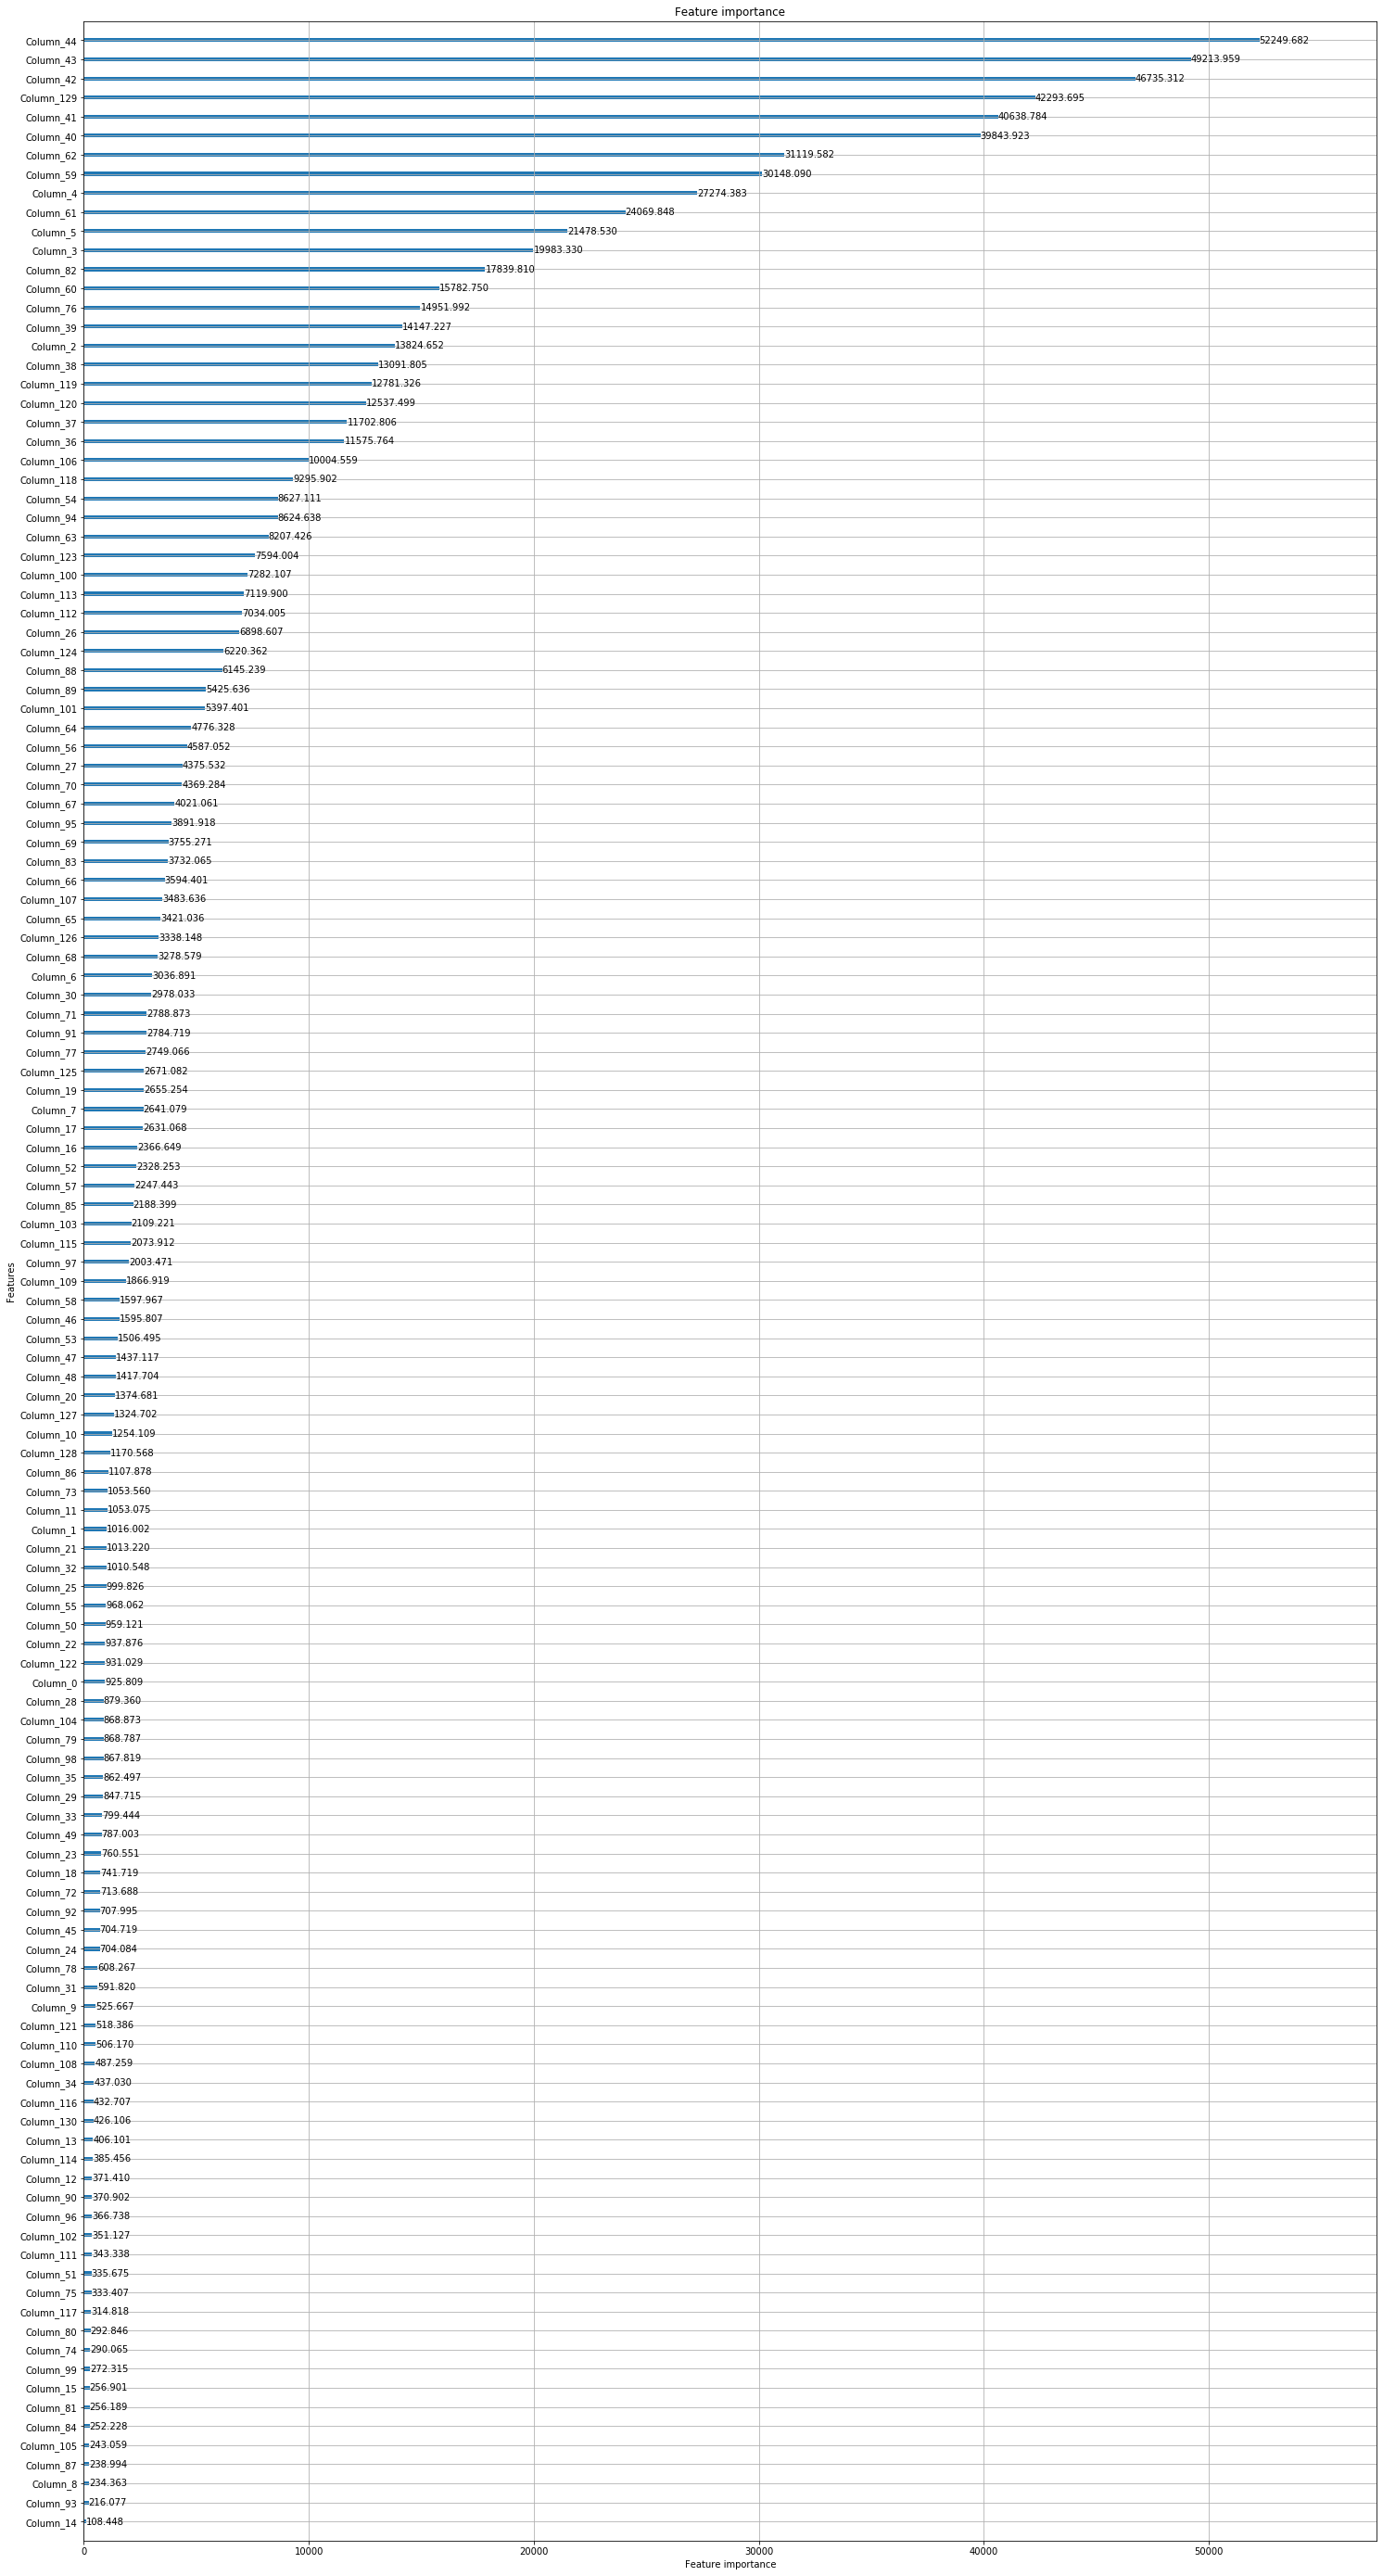

In [32]:
fig, ax = plt.subplots(figsize=(25, 50))
lgbm.plot_importance(models[4][4],
                     ax=ax,
                     importance_type='gain')
plt.show()

# train reg

In [37]:
y_data = train_df[resp_cols].values

In [39]:
params = {
    "num_leaves": 300,
    "max_bin": 450,
    "feature_fraction": 0.52,
    "bagging_fraction": 0.52,
    "objective": 'huber',
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "metric": "huber"
}

# multi folds
models = {}
mb = master_bar(cv.split(x_data,  y_data, groups=groups), total=5)
for fold, (trn_idx, val_idx) in enumerate(mb):
    logger.info(f'fold {fold}:')
    # multi labels
    fold_models = []
    pb = progress_bar(range(y_data.shape[1]), parent=mb)
    for i in pb:
        x_train = x_data[trn_idx]
        y_train = y_data[trn_idx, i]
        x_val = x_data[val_idx]
        y_val = y_data[val_idx, i]

        # lgbm dataset
        train_data = lgbm.Dataset(x_train, y_train)
        val_data = lgbm.Dataset(x_val, y_val, reference=train_data)
        
        # train
        clf = lgbm.train(params,
                         train_data,
                         valid_sets=[train_data, val_data],
                         num_boost_round=1000,
                         early_stopping_rounds=50,
                         verbose_eval=50)
        # record
        logger.info(f'model {i}: ')
        trn_preds = (clf.predict(x_train)>0.0).astype(int)
        val_preds = (clf.predict(x_val)>0.0).astype(int)
        y_train = (y_train > 0.0).astype(int)
        y_val = (y_val > 0.0).astype(int)
        logger.info(f'train acc: {accuracy_score(y_train, trn_preds): .4f}\t'  
                    f'val acc: {accuracy_score(y_val, val_preds): .4f}')
        logger.info(f'train auc: {roc_auc_score(y_train, trn_preds): .4f}\t'  
                    f'val auc: {roc_auc_score(y_val, val_preds): .4f}')        
        
        fold_models.append(clf)
    models[fold] = fold_models

fold 0:


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] Start training from score 0.000021
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 2.2297e-05	valid_1's huber: 4.2333e-05


model 0: 


Early stopping, best iteration is:
[9]	training's huber: 3.75284e-05	valid_1's huber: 4.18406e-05


train acc:  0.5587	val acc:  0.5222
train auc:  0.5587	val auc:  0.5241


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] Start training from score 0.000059
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 3.97249e-05	valid_1's huber: 7.92721e-05


model 1: 


Early stopping, best iteration is:
[6]	training's huber: 7.35058e-05	valid_1's huber: 7.79497e-05


train acc:  0.5493	val acc:  0.5160
train auc:  0.5463	val auc:  0.5117


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] Start training from score 0.000236
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 9.26868e-05	valid_1's huber: 0.000187667
Early stopping, best iteration is:
[2]	training's huber: 0.000190383	valid_1's huber: 0.000182784


model 2: 
train acc:  0.5431	val acc:  0.5075
train auc:  0.5308	val auc:  0.5020


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] Start training from score 0.000355
Training until validation scores don't improve for 50 rounds


model 3: 


[50]	training's huber: 0.00023274	valid_1's huber: 0.000562354
Early stopping, best iteration is:
[1]	training's huber: 0.00050689	valid_1's huber: 0.000551076


train acc:  0.5470	val acc:  0.5024
train auc:  0.5363	val auc:  0.5000


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 144426, number of used features: 131
[LightGBM] [Info] Start training from score 0.000241
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000153033	valid_1's huber: 0.000365352


model 4: 


Early stopping, best iteration is:
[4]	training's huber: 0.000316452	valid_1's huber: 0.00035593


train acc:  0.5575	val acc:  0.5088
train auc:  0.5499	val auc:  0.5040
fold 1:


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] Start training from score 0.000053
Training until validation scores don't improve for 50 rounds


model 0: 


[50]	training's huber: 2.87091e-05	valid_1's huber: 4.75571e-05
Early stopping, best iteration is:
[1]	training's huber: 4.13248e-05	valid_1's huber: 4.70899e-05


train acc:  0.5103	val acc:  0.5031
train auc:  0.5072	val auc:  0.5011


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] Start training from score 0.000100
Training until validation scores don't improve for 50 rounds


model 1: 


[50]	training's huber: 5.1602e-05	valid_1's huber: 8.99606e-05
Early stopping, best iteration is:
[1]	training's huber: 7.76897e-05	valid_1's huber: 8.89178e-05


train acc:  0.5163	val acc:  0.5045
train auc:  0.5089	val auc:  0.5008


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] Start training from score 0.000313
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000121748	valid_1's huber: 0.000213125


model 2: 


Early stopping, best iteration is:
[3]	training's huber: 0.000178007	valid_1's huber: 0.000210677


train acc:  0.5286	val acc:  0.5063
train auc:  0.5199	val auc:  0.5012


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] Start training from score 0.000638
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000329856	valid_1's huber: 0.000643369


model 3: 


Early stopping, best iteration is:
[9]	training's huber: 0.000454322	valid_1's huber: 0.000638196


train acc:  0.5400	val acc:  0.5071
train auc:  0.5341	val auc:  0.5025


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 372534, number of used features: 131
[LightGBM] [Info] Start training from score 0.000487
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000214869	valid_1's huber: 0.000431909


model 4: 


Early stopping, best iteration is:
[15]	training's huber: 0.000277223	valid_1's huber: 0.000429312


train acc:  0.5444	val acc:  0.5084
train auc:  0.5382	val auc:  0.5048
fold 2:


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.310993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] Start training from score 0.000055
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 3.40469e-05	valid_1's huber: 3.77934e-05


model 0: 


Early stopping, best iteration is:
[13]	training's huber: 4.01589e-05	valid_1's huber: 3.76979e-05


train acc:  0.5395	val acc:  0.5293
train auc:  0.5388	val auc:  0.5280


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] Start training from score 0.000104
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 6.24015e-05	valid_1's huber: 7.37664e-05


model 1: 


Early stopping, best iteration is:
[17]	training's huber: 7.21833e-05	valid_1's huber: 7.35307e-05


train acc:  0.5371	val acc:  0.5208
train auc:  0.5342	val auc:  0.5177


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] Start training from score 0.000265
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000144058	valid_1's huber: 0.000187646


model 2: 


Early stopping, best iteration is:
[3]	training's huber: 0.000185615	valid_1's huber: 0.000186308


train acc:  0.5231	val acc:  0.5065
train auc:  0.5160	val auc:  0.5011


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] Start training from score 0.000547
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000396887	valid_1's huber: 0.000548768


model 3: 


Early stopping, best iteration is:
[14]	training's huber: 0.000485624	valid_1's huber: 0.000545726


train acc:  0.5354	val acc:  0.5055
train auc:  0.5303	val auc:  0.5021


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 621401, number of used features: 131
[LightGBM] [Info] Start training from score 0.000447
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000263536	valid_1's huber: 0.000358804


model 4: 


Early stopping, best iteration is:
[22]	training's huber: 0.000304308	valid_1's huber: 0.000356658


train acc:  0.5402	val acc:  0.5078
train auc:  0.5354	val auc:  0.5050
fold 3:


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] Start training from score 0.000067
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 3.51789e-05	valid_1's huber: 3.70667e-05


model 0: 


Early stopping, best iteration is:
[37]	training's huber: 3.67375e-05	valid_1's huber: 3.70394e-05


train acc:  0.5486	val acc:  0.5363
train auc:  0.5488	val auc:  0.5365


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.380102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] Start training from score 0.000128
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 6.50361e-05	valid_1's huber: 6.79542e-05


model 1: 


Early stopping, best iteration is:
[11]	training's huber: 7.5264e-05	valid_1's huber: 6.77382e-05


train acc:  0.5266	val acc:  0.5119
train auc:  0.5219	val auc:  0.5100


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.475540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] Start training from score 0.000232
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000153295	valid_1's huber: 0.000164848
Early stopping, best iteration is:
[1]	training's huber: 0.000189496	valid_1's huber: 0.000162913


model 2: 
train acc:  0.5141	val acc:  0.5023
train auc:  0.5070	val auc:  0.5003


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] Start training from score 0.000457
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000437566	valid_1's huber: 0.000506785


model 3: 


Early stopping, best iteration is:
[5]	training's huber: 0.000537169	valid_1's huber: 0.000498625


train acc:  0.5219	val acc:  0.5001
train auc:  0.5172	val auc:  0.5024


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 889748, number of used features: 131
[LightGBM] [Info] Start training from score 0.000429
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000289416	valid_1's huber: 0.000344398


model 4: 


Early stopping, best iteration is:
[3]	training's huber: 0.000365282	valid_1's huber: 0.000337495


train acc:  0.5171	val acc:  0.4983
train auc:  0.5119	val auc:  0.5025
fold 4:


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.519334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] Start training from score 0.000061
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 3.50885e-05	valid_1's huber: 3.93747e-05
[100]	training's huber: 3.13974e-05	valid_1's huber: 3.93152e-05
[150]	training's huber: 2.89087e-05	valid_1's huber: 3.92992e-05
Early stopping, best iteration is:
[144]	training's huber: 2.91512e-05	valid_1's huber: 3.92898e-05


model 0: 
train acc:  0.5705	val acc:  0.5449
train auc:  0.5708	val auc:  0.5454


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.482739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] Start training from score 0.000108
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 6.49563e-05	valid_1's huber: 7.54958e-05
[100]	training's huber: 5.85588e-05	valid_1's huber: 7.54286e-05


model 1: 


Early stopping, best iteration is:
[83]	training's huber: 6.03684e-05	valid_1's huber: 7.53771e-05


train acc:  0.5542	val acc:  0.5344
train auc:  0.5543	val auc:  0.5345


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.533291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] Start training from score 0.000174
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000155696	valid_1's huber: 0.000180067
[100]	training's huber: 0.000142252	valid_1's huber: 0.000179851


model 2: 


Early stopping, best iteration is:
[87]	training's huber: 0.000145313	valid_1's huber: 0.000179717


train acc:  0.5550	val acc:  0.5201
train auc:  0.5545	val auc:  0.5198


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] Start training from score 0.000333
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000450034	valid_1's huber: 0.000525993


model 3: 


Early stopping, best iteration is:
[30]	training's huber: 0.000475717	valid_1's huber: 0.000525112


train acc:  0.5355	val acc:  0.5084
train auc:  0.5344	val auc:  0.5087


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.527375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58950
[LightGBM] [Info] Number of data points in the train set: 1175505, number of used features: 131
[LightGBM] [Info] Start training from score 0.000323
Training until validation scores don't improve for 50 rounds
[50]	training's huber: 0.000298507	valid_1's huber: 0.000356349


model 4: 


Early stopping, best iteration is:
[37]	training's huber: 0.000308785	valid_1's huber: 0.000355946


train acc:  0.5373	val acc:  0.5108
train auc:  0.5360	val auc:  0.5113


In [40]:
model_name = 'lgb_model_reg.bin'
save_pickle(models, model_name)

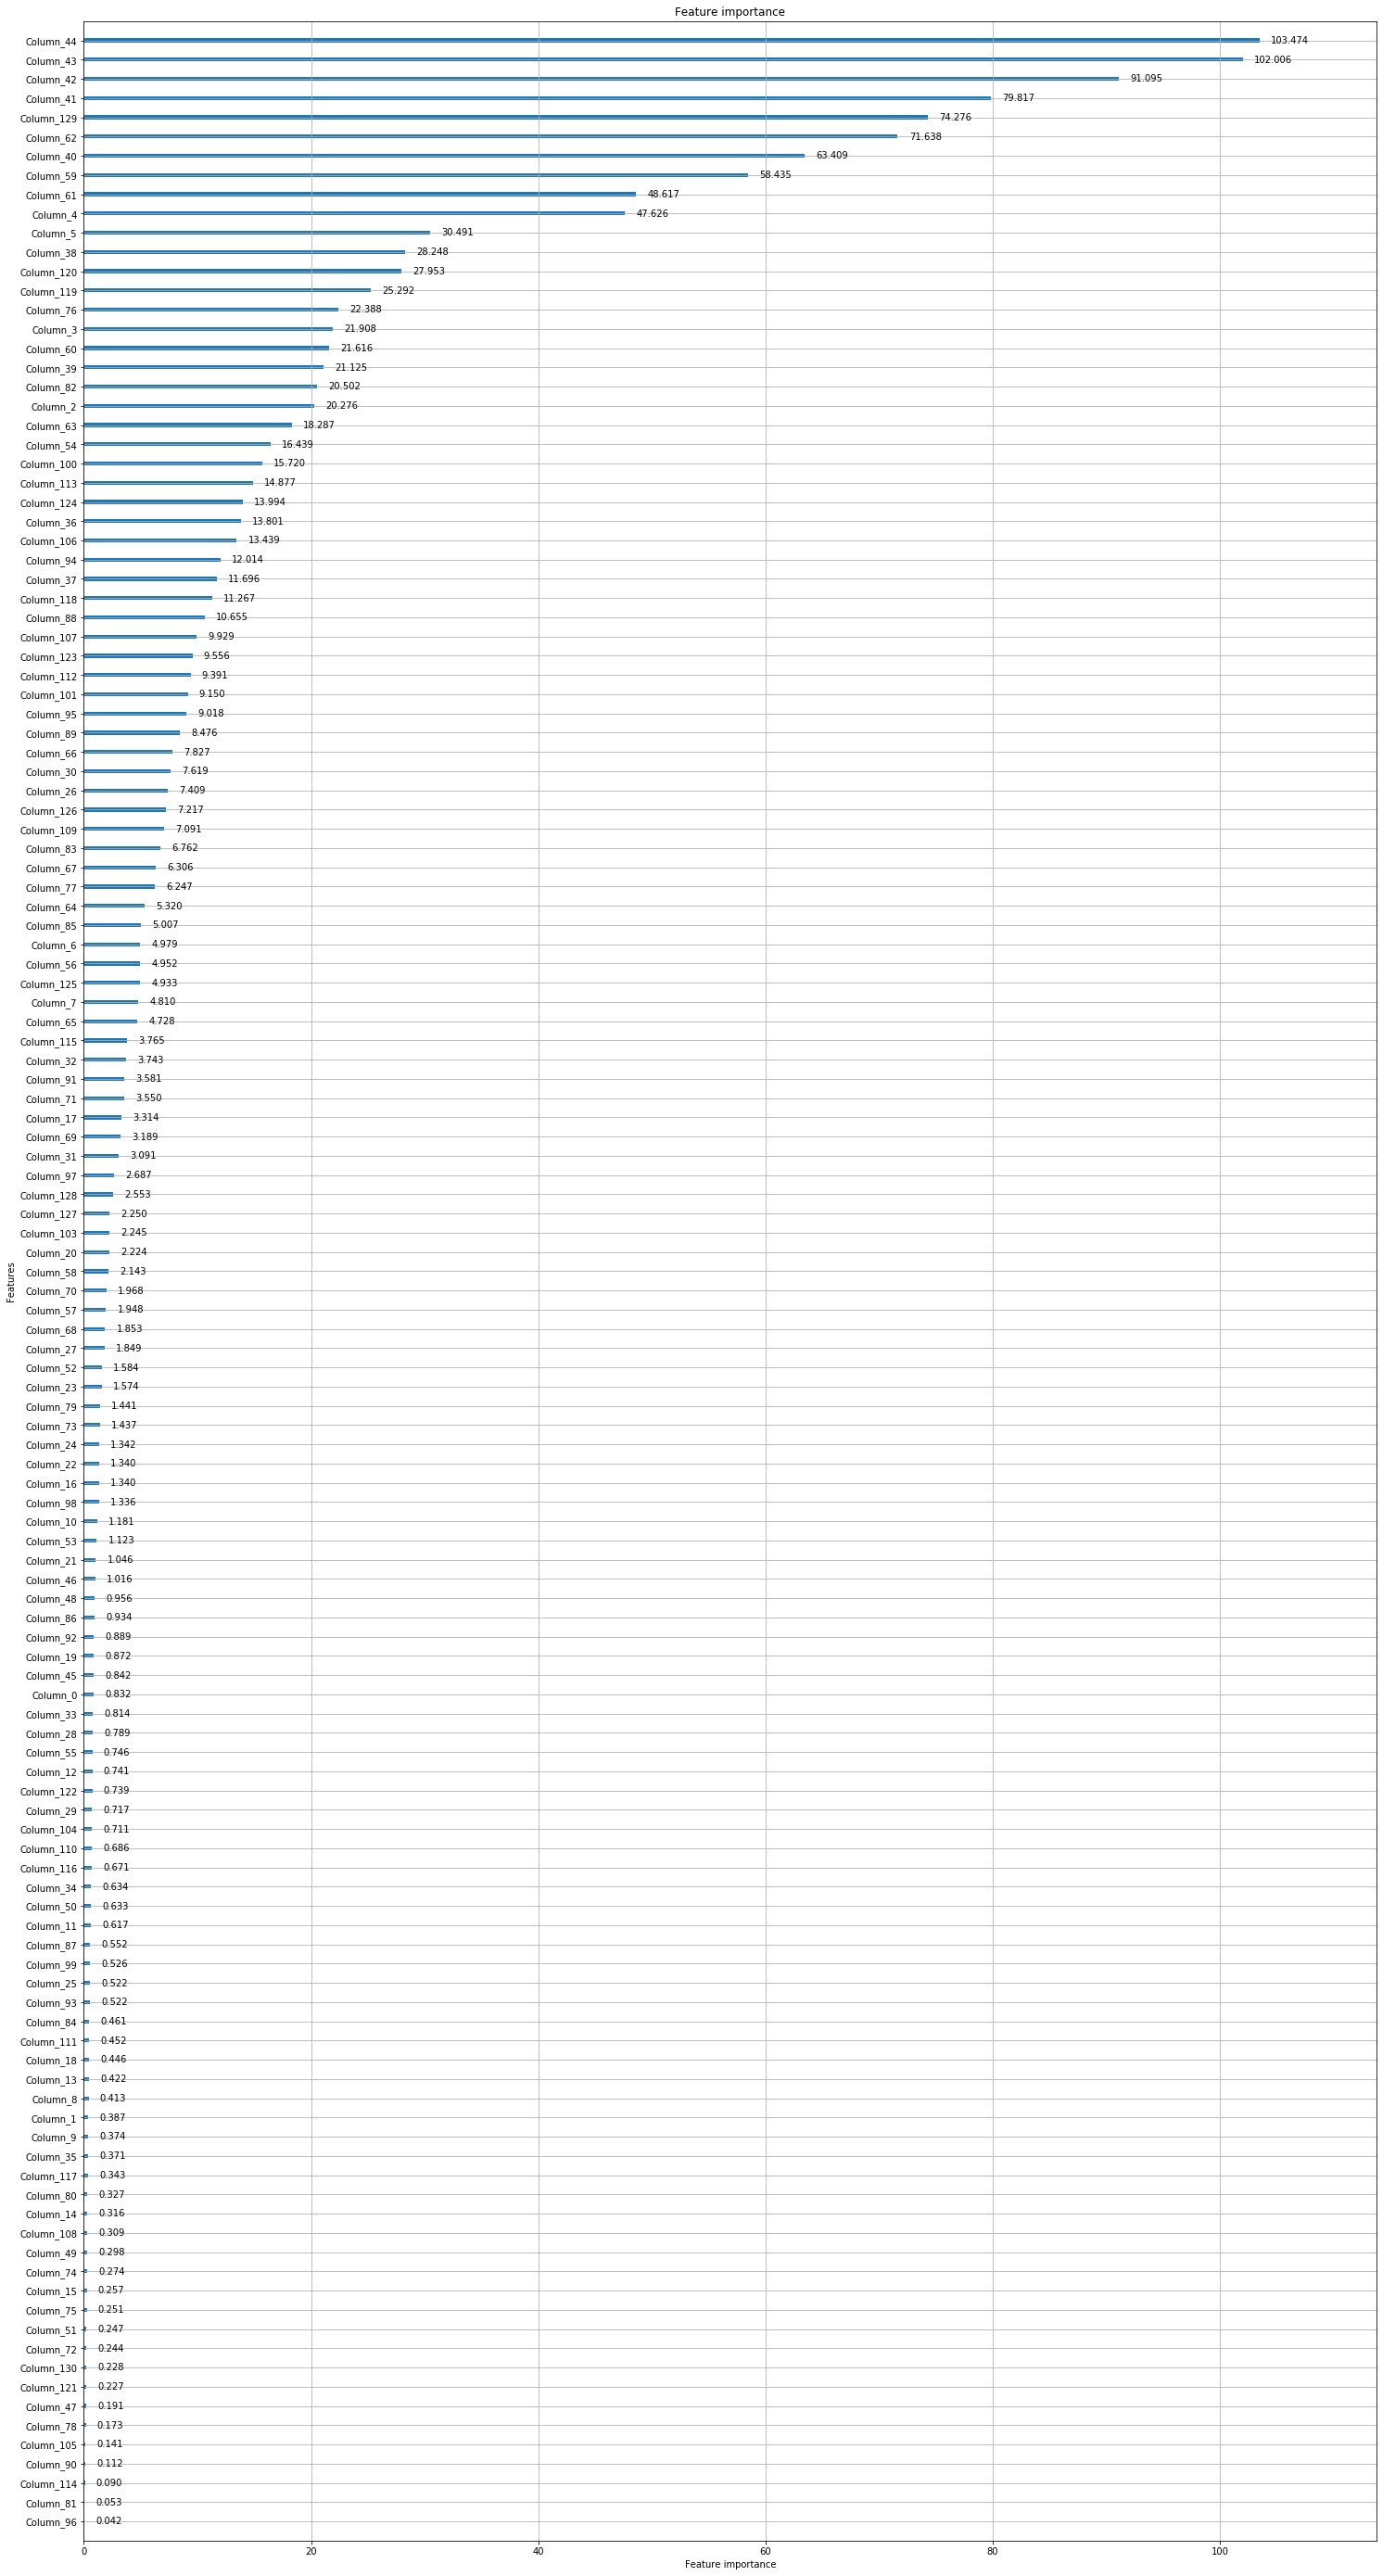

In [41]:
fig, ax = plt.subplots(figsize=(25, 50))
lgbm.plot_importance(models[4][4],
                     ax=ax,
                     importance_type='gain')
plt.show()